In [37]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [38]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [39]:
dataset = read_csv('input2.csv', header = 0, index_col=0)
values = dataset.values
encoder = LabelEncoder()
values[:,2] = encoder.fit_transform(values[:,2])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis = 1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.243070   0.590510   0.159926  0.240938  0.657293  0.150735
2   0.240938   0.657293   0.150735  0.243070  0.578207  0.176471
3   0.243070   0.578207   0.176471  0.240938  0.636204  0.165441
4   0.240938   0.636204   0.165441  0.211087  0.576450  0.178309
5   0.211087   0.576450   0.178309  0.208955  0.623902  0.165441


In [40]:
values = reframed.values
n_train_hours = 300
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:,:-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((300, 1, 5), (300,), (377, 1, 5), (377,))


In [41]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 300 samples, validate on 377 samples
Epoch 1/50
1s - loss: 0.0017 - val_loss: 0.0211
Epoch 2/50
0s - loss: 0.0050 - val_loss: 0.0164
Epoch 3/50
0s - loss: 0.0033 - val_loss: 0.0131
Epoch 4/50
0s - loss: 0.0023 - val_loss: 0.0109
Epoch 5/50
0s - loss: 0.0017 - val_loss: 0.0096
Epoch 6/50
0s - loss: 0.0014 - val_loss: 0.0088
Epoch 7/50
0s - loss: 0.0012 - val_loss: 0.0083
Epoch 8/50
0s - loss: 0.0011 - val_loss: 0.0080
Epoch 9/50
0s - loss: 9.8289e-04 - val_loss: 0.0079
Epoch 10/50
0s - loss: 9.3870e-04 - val_loss: 0.0078
Epoch 11/50
0s - loss: 9.0881e-04 - val_loss: 0.0078
Epoch 12/50
0s - loss: 8.8802e-04 - val_loss: 0.0078
Epoch 13/50
0s - loss: 8.7066e-04 - val_loss: 0.0078
Epoch 14/50
0s - loss: 8.5631e-04 - val_loss: 0.0078
Epoch 15/50
0s - loss: 8.4560e-04 - val_loss: 0.0078
Epoch 16/50
1s - loss: 8.3699e-04 - val_loss: 0.0078
Epoch 17/50
0s - loss: 8.3040e-04 - val_loss: 0.0079
Epoch 18/50
0s - loss: 8.2413e-04 - val_loss: 0.0079
Epoch 19/50
0s - loss: 8.1964e-04 - val_l

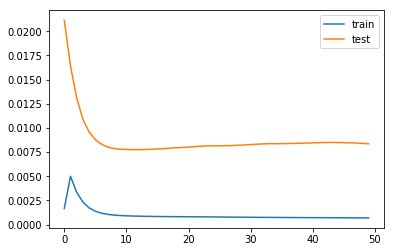

In [42]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [43]:
yhat =  model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
print test_X

inv_yhat = concatenate((yhat, test_X[:,1:]), axis=1)
print inv_yhat
#inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis =1)
#inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

[[ 0.26865673  0.14938489  0.72610295  0.52025586  0.70650268]
 [ 0.52025586  0.70650268  0.60110295  0.52025586  0.86994731]
 [ 0.52025586  0.86994731  0.63235295  0.52025586  0.64147627]
 ..., 
 [ 0.4029851   0.57996488  0.50919116  0.4029851   0.56063271]
 [ 0.4029851   0.56063271  0.5         0.4029851   0.63796139]
 [ 0.4029851   0.63796139  0.4834559   0.4029851   0.61862922]]
[[ 0.50678504  0.14938489  0.72610295  0.52025586  0.70650268]
 [ 0.74053788  0.70650268  0.60110295  0.52025586  0.86994731]
 [ 0.83919716  0.86994731  0.63235295  0.52025586  0.64147627]
 ..., 
 [ 0.57475913  0.57996488  0.50919116  0.4029851   0.56063271]
 [ 0.56282437  0.56063271  0.5         0.4029851   0.63796139]
 [ 0.58987069  0.63796139  0.4834559   0.4029851   0.61862922]]
Test RMSE: 0.091
